# RAG from Scratch
**Retrieval-Augmented Generation (PDF) + FAISS + GROQ**

This is a complete RAG pipeline from the ground up:
1. **Parse** your PDF into text chunks
2. **Embed** chunks using a sentence transformer
3. **Index** embeddings in a FAISS vector store
4. **Retrieve** relevant chunks at query time
5. **Generate** answers with GROQ AI
6. **Compare** RAG answers vs. Groq with no context


## 1. Install Dependencies

In [ ]:
!pip install pymupdf faiss-cpu sentence-transformers pandas matplotlib groq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 6.8 MB/s eta 0:00:00


In [47]:
import fitz  # PyMuPDF
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap
import re
from groq import Groq # New import for Groq API
from sentence_transformers import SentenceTransformer
from IPython.display import display, Markdown

print('All imports successful!')

All imports successful!


## 2. Configuration

In [ ]:
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROK_API_KEY')
PDF_PATH = "/content/ml-for-everyone.pdf" #Replace this with any pdf

# RAG settings
CHUNK_SIZE    = 500 
CHUNK_OVERLAP = 50    
TOP_K         = 3     

# Picking a right embedding model is crucial for better performance..This is free and no api is needed. 
EMBED_MODEL = "all-MiniLM-L6-v2"
GROQ_MODEL = "llama-3.3-70b-versatile" # Pick any model of your choice.. 
print('Configuration set!')

Configuration set!


## 3. Step 1 — Parse PDF into Text Chunks

We extract raw text from every page, then split into overlapping chunks. Overlap ensures that sentences split across chunk boundaries aren't lost.

In [ ]:
def extract_text_from_pdf(pdf_path):
    """Extract full text from a PDF using PyMuPDF."""
    doc = fitz.open(pdf_path)
    full_text = ""
    for page_num, page in enumerate(doc):
        text = page.get_text()
        full_text += f"\n[PAGE {page_num + 1}]\n{text}"
    doc.close()
    return full_text


def chunk_text(text, chunk_size=CHUNK_SIZE, overlap=CHUNK_OVERLAP):
    """Sentence-aware chunker — never splits mid-sentence."""

    # Clean up excessive whitespace and page markers
    text = re.sub(r'\[PAGE \d+\]', '', text)
    text = re.sub(r'\n{3,}', '\n\n', text)
    text = text.strip()

    # Split into sentences
    sentences = re.split(r'(?<=[.?!])\s+', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    chunks = []
    current_chunk = []
    current_len = 0

    for sentence in sentences:
        sentence_len = len(sentence)

        if current_len + sentence_len > chunk_size and current_chunk:
            chunks.append(' '.join(current_chunk))

            # Keep last few sentences as overlap
            overlap_chunk = []
            overlap_len = 0
            for s in reversed(current_chunk):
                if overlap_len + len(s) <= overlap:
                    overlap_chunk.insert(0, s)
                    overlap_len += len(s)
                else:
                    break
            current_chunk = overlap_chunk
            current_len = overlap_len

        current_chunk.append(sentence)
        current_len += sentence_len

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks


raw_text = extract_text_from_pdf(PDF_PATH)
chunks   = chunk_text(raw_text)

print(f'PDF parsed successfully!')
print(f'Total characters : {len(raw_text):,}')
print(f'Total chunks     : {len(chunks)}')
print(f'Avg chunk length : {np.mean([len(c) for c in chunks]):.0f} chars')
print(f'\n--- Sample Chunk (chunk #3) ---')
print(textwrap.fill(chunks[2], width=80))

PDF parsed successfully!
Total characters : 34,701
Total chunks     : 79
Avg chunk length : 445 chars

--- Sample Chunk (chunk #3) ---
Only real-world problems, practical solutions,  simple language, and no high-
level theorems. One and for everyone. Whether you are a programmer or a manager.
Let's roll. add a comment here  The map of the machine learning  world Part 1.
Classical Machine Learning The first methods came from pure statistics in the
'50s. They solved  formal math tasks — searching for patterns in numbers,
evaluating  the proximity of data points, and calculating vectors' directions.


## 4. Step 2 — Embed Chunks with Sentence Transformers

`all-MiniLM-L6-v2` is a lightweight but powerful embedding model. It maps each text chunk to a 384-dimensional dense vector. Semantically similar chunks end up close in this vector space — that's what makes retrieval work.

In [75]:
print('Loading embedding model...')
embedder = SentenceTransformer(EMBED_MODEL)

print(f'Embedding {len(chunks)} chunks...')
embeddings = embedder.encode(chunks, show_progress_bar=True, convert_to_numpy=True)

print(f'\nEmbedding matrix shape: {embeddings.shape}')
print(f'Each chunk → {embeddings.shape[1]}-dimensional vector')

Loading embedding model...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding 79 chunks...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


Embedding matrix shape: (79, 384)
Each chunk → 384-dimensional vector


## 5. Step 3 — Build FAISS Vector Index

FAISS (Facebook AI Similarity Search) lets us do **approximate nearest-neighbor search** over the embeddings extremely fast. We use a flat L2 index here — exact but fast enough for small corpora.

In [ ]:
dimension = embeddings.shape[1]

# Normalize for cosine similarity (optional but recommended)
faiss.normalize_L2(embeddings)

index = faiss.IndexFlatIP(dimension)
index.add(embeddings)

print(f'FAISS index built!')
print(f'Index type     : IndexFlatIP (exact cosine similarity)')
print(f'Vectors stored : {index.ntotal}')
print(f'Dimension      : {dimension}')

FAISS index built!
Index type     : IndexFlatIP (exact cosine similarity)
Vectors stored : 79
Dimension      : 384


## 6. Step 4 — Retrieval Function

Given a query, we embed it using the same model, then search FAISS for the top-K most similar chunks.

In [77]:
def retrieve(query, top_k=TOP_K, verbose=True):
    """
    Embed the query, search FAISS, return top-k chunks with scores.
    """
    query_vec = embedder.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(query_vec)

    scores, indices = index.search(query_vec, top_k)

    results = []
    for rank, (score, idx) in enumerate(zip(scores[0], indices[0])):
        results.append({
            "rank"  : rank + 1,
            "score" : float(score),
            "chunk_id": int(idx),
            "text"  : chunks[idx]
        })

    if verbose:
        print(f'Query: "{query}"')
        print(f'Top {top_k} retrieved chunks:\n')
        for r in results:
            print(f'  Rank {r["rank"]} | Score: {r["score"]:.4f} | Chunk #{r["chunk_id"]}')
            print(f'  {"-"*60}')
            print(textwrap.fill(r["text"][:300] + "...", width=70, initial_indent="  ", subsequent_indent="  "))
            print()

    return results


# Quick test
test_query = "What is the main topic of this document?"
_ = retrieve(test_query)

Query: "What is the main topic of this document?"
Top 3 retrieved chunks:

  Rank 1 | Score: 0.2309 | Chunk #1
  ------------------------------------------------------------
  If you  ever tried to read articles about machine learning on the
  Internet,  vas3k.com  most likely you stumbled upon two types of
  them: thick academic  trilogies filled with theorems (I couldn’t
  even get through half of one)  or fishy fairytales about artificial
  intelligence, data-science magic, an...

  Rank 2 | Score: 0.2202 | Chunk #8
  ------------------------------------------------------------
  Separate socks by based on color, documents based on language, music
  by genre" Today used for: – Spam filtering – Language detection – A
  search of similar documents – Sentiment analysis – Recognition of
  handwritten characters and numbers – Fraud detection Popular
  algorithms: Naive Bayes, Decision T...

  Rank 3 | Score: 0.2157 | Chunk #0
  ------------------------------------------------------------

## 7. Step 5 — Answer Generation

We define two functions:
- `answer_with_rag()` — injects retrieved chunks as context before asking GROQ
- `answer_without_rag()` — asks GROQ the same question with **no context** (pure parametric memory)

Comparing both reveals exactly what RAG adds.

In [ ]:
client = Groq(api_key=GROQ_API_KEY)


def answer_with_rag(query, top_k=TOP_K):
    """Retrieve relevant chunks, then ask Groq with context."""
    retrieved = retrieve(query, top_k=top_k, verbose=False)

    context = "\n\n---\n\n".join([f"[Chunk {r['chunk_id']}]\n{r['text']}" for r in retrieved])

    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant. Answer the question using ONLY the provided context.\nIf the answer isn't in the context, say \"I couldn't find this in the document.\""
        },
        {
            "role": "user",
            "content": f"CONTEXT:\n{context}\n\nQUESTION: {query}\n\nANSWER:"
        }
    ]

    chat_completion = client.chat.completions.create(
        messages=messages,
        model=GROQ_MODEL,
        temperature=0.0 #Temperature is 0 for more factual answers..
    )
    return chat_completion.choices[0].message.content.strip(), retrieved


def answer_without_rag(query):
    """Ask Groq the same question with NO context (baseline)."""
    messages = [
        {
            "role": "system",
            "content": "Answer the following question as best you can."
        },
        {
            "role": "user",
            "content": f"QUESTION: {query}\n\nANSWER:"
        }
    ]

    chat_completion = client.chat.completions.create(
        messages=messages,
        model=GROQ_MODEL,
        temperature=0.7 # Higher temperature for creative/general answers
    )
    return chat_completion.choices[0].message.content.strip()


print('Groq functions ready!')

Groq functions ready!


## 8. Step 6 — Ask Questions & Compare RAG vs No-RAG

Define your questions below. These should be things actually answerable from your PDF.

In [ ]:
QUESTIONS = [
    "What is dimensionality reduction?",
    "Explain Convolution Neural Networks"
]

print(f'{len(QUESTIONS)} questions defined. Running RAG pipeline...')

2 questions defined. Running RAG pipeline...


In [ ]:
all_results = []

for i, question in enumerate(QUESTIONS):
    print(f'\n{"="*70}')
    print(f'Q{i+1}: {question}')
    print(f'{"="*70}')

    # --- RAG Answer ---
    rag_answer, retrieved_chunks = answer_with_rag(question)

    # --- No-RAG Answer ---
    no_rag_answer = answer_without_rag(question)

    # --- Show retrieved chunks ---
    print(f'\nRetrieved Chunks (used as context):')
    for r in retrieved_chunks:
        print(f'  Chunk #{r["chunk_id"]} | Similarity: {r["score"]:.4f}')
        print(f'  {textwrap.fill(r["text"][:200] + "...", 65, initial_indent="  ", subsequent_indent="  ")}')
        print()

    # --- Show both answers ---
    print(f'GROQ WITHOUT RAG (no context):')
    print(textwrap.fill(no_rag_answer, 70, initial_indent='  ', subsequent_indent='  '))

    print(f'\nGROK WITH RAG (grounded in your PDF):')
    print(textwrap.fill(rag_answer, 70, initial_indent='  ', subsequent_indent='  '))

    all_results.append({
        "question"      : question,
        "rag_answer"    : rag_answer,
        "no_rag_answer" : no_rag_answer,
        "top_chunk_score": retrieved_chunks[0]["score"],
        "chunks_used"   : [r["chunk_id"] for r in retrieved_chunks]
    })

## 9. Side-by-Side Comparison Table

In [ ]:
df_results = pd.DataFrame(all_results)
df_display = df_results[["question", "no_rag_answer", "rag_answer", "top_chunk_score"]].copy()
df_display["no_rag_answer"] = df_display["no_rag_answer"].str[:200] + "..."
df_display["rag_answer"]    = df_display["rag_answer"].str[:200] + "..."
df_display.columns = ["Question", "GROQ (No RAG)", "GROQ + RAG", "Top Retrieval Score"]
df_display = df_display.set_index("Question")

pd.set_option('display.max_colwidth', 200)
display(df_display)

,GROQ (No RAG),GROQ + RAG,Top Retrieval Score
Question,,,
What is dimensionality reduction?,Dimensionality reduction is a process in data analysis and machine learning that involves reducing the number of features or dimensions in a dataset while preserving as much information as possibl...,"Dimensionality reduction is a process that ""Assembles specific features into more high-level ones"" and is used for various applications such as recommender systems, visualizations, and topic model...",0.431740
Explain Convolution Neural Networks,**Convolutional Neural Networks (CNNs)**\n\nConvolutional Neural Networks (CNNs) are a type of neural network architecture that are particularly well-suited for image and video processing tasks. T...,"Convolutional Neural Networks (CNNs) are a type of neural network used to search for objects on photos and in videos, face recognition, style transfer, generating and enhancing images, creating ef...",0.624342


## 10. Visualization — Retrieval Score per Question

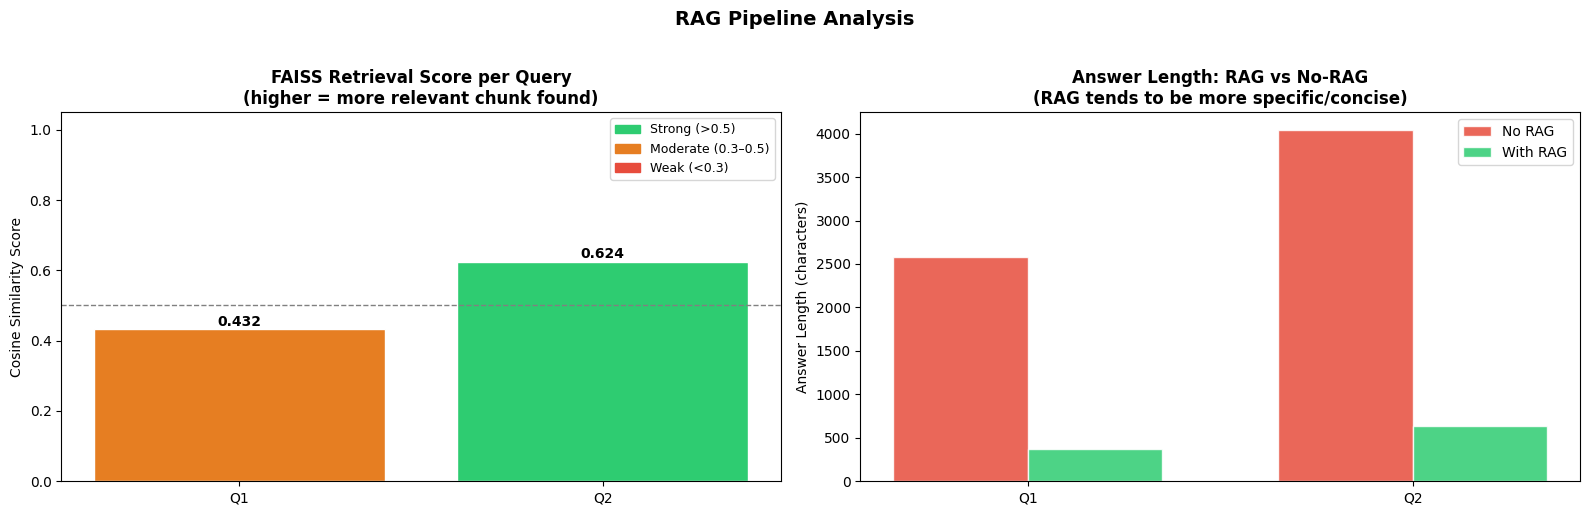

Chart saved to rag_analysis.png


In [85]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Plot 1: Top retrieval score per question ---
ax1 = axes[0]
q_labels = [f"Q{i+1}" for i in range(len(all_results))]
scores = [r["top_chunk_score"] for r in all_results]
colors = ["#2ecc71" if s > 0.5 else "#e67e22" if s > 0.3 else "#e74c3c" for s in scores]

bars = ax1.bar(q_labels, scores, color=colors, edgecolor="white", linewidth=1)
ax1.axhline(y=0.5, color="gray", linestyle="--", linewidth=1, label="Good retrieval threshold (0.5)")
ax1.set_ylim(0, 1.05)
ax1.set_ylabel("Cosine Similarity Score")
ax1.set_title("FAISS Retrieval Score per Query\n(higher = more relevant chunk found)", fontweight="bold")
ax1.legend(fontsize=9)
for bar, score in zip(bars, scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.3f}", ha="center", fontsize=10, fontweight="bold")

green_patch  = mpatches.Patch(color='#2ecc71', label='Strong (>0.5)')
orange_patch = mpatches.Patch(color='#e67e22', label='Moderate (0.3–0.5)')
red_patch    = mpatches.Patch(color='#e74c3c', label='Weak (<0.3)')
ax1.legend(handles=[green_patch, orange_patch, red_patch], fontsize=9, loc='upper right')

# --- Plot 2: Answer length comparison (RAG vs no-RAG) ---
ax2 = axes[1]
rag_lengths    = [len(r["rag_answer"]) for r in all_results]
no_rag_lengths = [len(r["no_rag_answer"]) for r in all_results]
x = np.arange(len(q_labels))
width = 0.35

ax2.bar(x - width/2, no_rag_lengths, width, label="No RAG",  color="#e74c3c", alpha=0.85, edgecolor="white")
ax2.bar(x + width/2, rag_lengths,    width, label="With RAG", color="#2ecc71", alpha=0.85, edgecolor="white")
ax2.set_xticks(x)
ax2.set_xticklabels(q_labels)
ax2.set_ylabel("Answer Length (characters)")
ax2.set_title("Answer Length: RAG vs No-RAG\n(RAG tends to be more specific/concise)", fontweight="bold")
ax2.legend()

plt.suptitle("RAG Pipeline Analysis", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("rag_analysis.png", dpi=150, bbox_inches="tight")
plt.show()
print("Chart saved to rag_analysis.png")